In [ ]:
!pip install yfinance

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


pred: 21097.66
actual: 21370.75
MAE (last 60 min): 0.013664
MSE (last 60 min): 0.000187


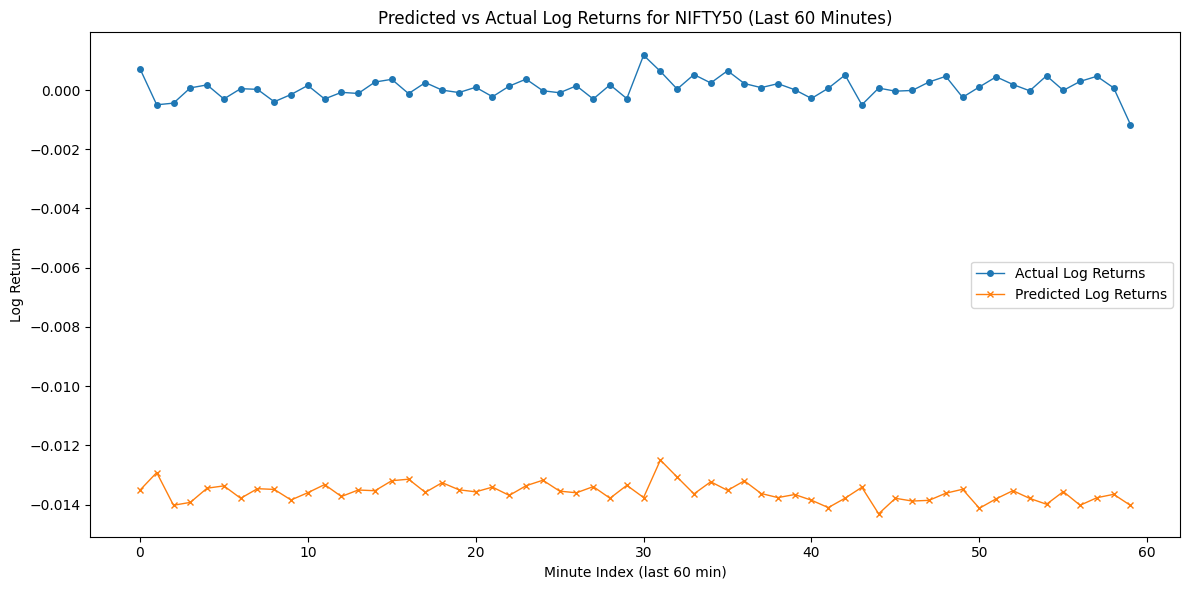

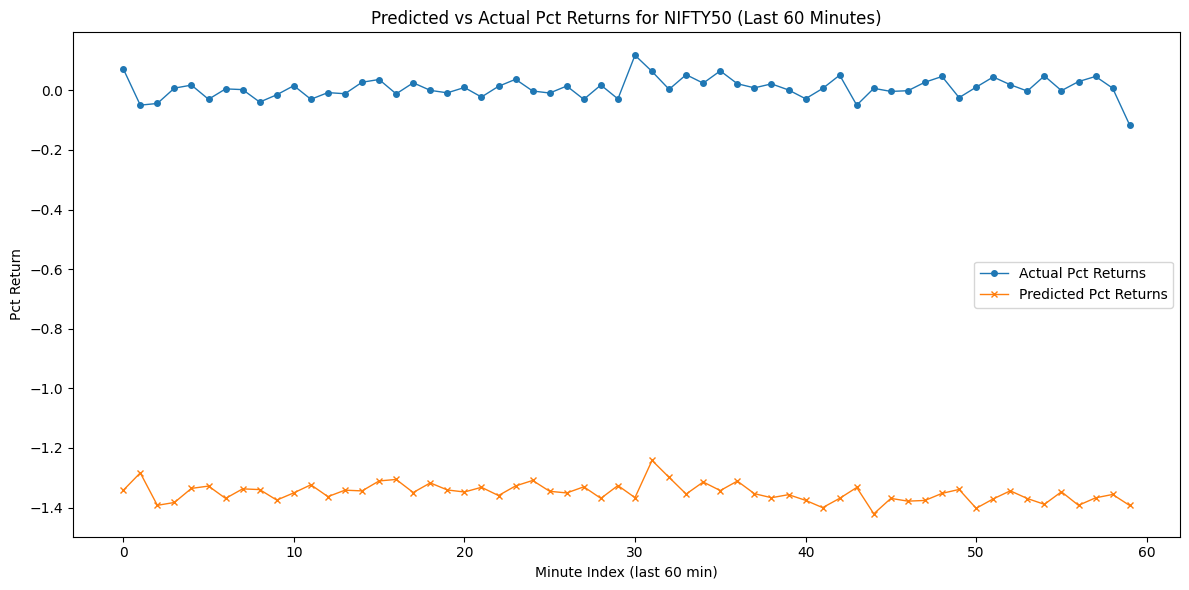

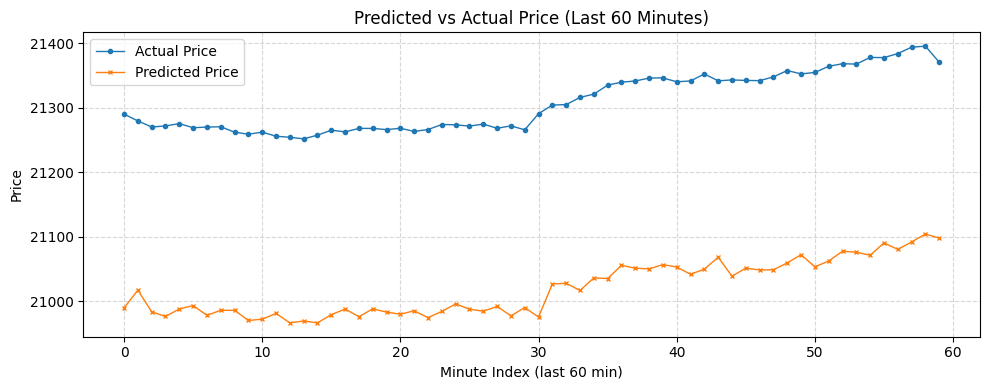

In [1]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
from google.colab import files, drive
from datetime import timedelta
import warnings

# Upload files
# uploaded = files.upload()
drive.mount('/content/drive')

# Path to CSV file
csv_filename = "/content/drive/MyDrive/LSTM/NIFTY50.csv"

# Load DataFrame from CSV
df = pd.read_csv(csv_filename)

symbol="NIFTY50"

# Ensure datetime index (assume 'Datetime' or similar column exists)
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df = df.set_index('Datetime')
elif 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index('datetime')
elif 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

# Make sure data is sorted
df = df.sort_index()

# Use only the last 2 days for prediction
if len(df) > 0:
    last_timestamp = df.index[-1]
    cutoff_time = last_timestamp - timedelta(days=2)
    df = df[df.index > cutoff_time]

if df.empty:
    raise ValueError("No data found in the last 2 days of the CSV file.")

# Use 'close' and calculate returns
if 'close' not in df.columns:
    df['close'] = df['Close'] if 'Close' in df.columns else df.iloc[:, 3]  # fallback

df['Returns'] = df['close'].pct_change()
df.dropna(inplace=True)
df = df.reset_index(drop=True)

# --- Only use the last 61 rows (for 60 min returns) ---
if len(df) < 61:
    raise ValueError("Not enough data for last 60 minutes calculation.")
df_60 = df.iloc[-61:].reset_index(drop=True)

model_path = "/content/drive/MyDrive/LSTM/lstm_returns/lstm_minute_csv_20250518_25y.h5"  # Adjust as needed
scaler_path = "/content/drive/MyDrive/LSTM/lstm_returns/scaler_minute_csv_25y.pkl"
custom_objects = {"mse": MeanSquaredError()}
model = load_model(model_path, custom_objects=custom_objects)
scaler = joblib.load(scaler_path)

# Prepare arrays to store results
log_return_predicted = []
log_return_actual = []
pct_return_predicted = []
pct_return_actual = []
predicted_prices = []
actual_prices = []

for i in range(1, len(df_60)):
    # last minute's data for prediction (use previous minute's close and return)
    last_minute_data = df_60[['close', 'Returns']].iloc[i-1].values.reshape(1, 2)
    #suppress logs
    warnings.filterwarnings("ignore", message="X does not have valid feature names, but MinMaxScaler was fitted with feature names")
    # scale data
    scaled_input = scaler.transform(last_minute_data)
    # reshape for LSTM
    X_input = scaled_input.reshape((1, 2, 1))
    # predict
    scaled_prediction = model.predict(X_input, verbose=0)
    # inverse transform to get predicted price
    predicted_price = scaler.inverse_transform([[scaled_prediction[0][0], 0]])[0][0]

    # get actual close and previous close
    actual_close = df_60['close'].iloc[i]
    prev_close = df_60['close'].iloc[i-1]

    # log returns
    log_ret_pred = np.log(predicted_price / prev_close)
    log_ret_actual = np.log(actual_close / prev_close)

    # percentage returns
    pct_ret_pred = ((predicted_price - prev_close) / prev_close) * 100
    pct_ret_actual = ((actual_close - prev_close) / prev_close) * 100

    log_return_predicted.append(log_ret_pred)
    log_return_actual.append(log_ret_actual)
    pct_return_predicted.append(pct_ret_pred)
    pct_return_actual.append(pct_ret_actual)
    predicted_prices.append(predicted_price)
    actual_prices.append(actual_close)

# Convert to numpy arrays for metrics
log_return_predicted = np.array(log_return_predicted)
log_return_actual = np.array(log_return_actual)
pct_return_predicted = np.array(pct_return_predicted)
pct_return_actual = np.array(pct_return_actual)
predicted_prices = np.array(predicted_prices)
actual_prices = np.array(actual_prices)

# --- Metrics Calculation ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(log_return_actual, log_return_predicted)
mse = mean_squared_error(log_return_actual, log_return_predicted)
# mape = np.mean(np.abs((log_return_actual - log_return_predicted) / (log_return_actual + 1e-8))) * 100

print(f"pred: {predicted_price:.2f}")
print(f"actual: {df_60['close'].iloc[i]:.2f}")

print(f"MAE (last 60 min): {mae:.6f}")
print(f"MSE (last 60 min): {mse:.6f}")
# print(f"MAPE (last 60 min): {mape:.2f}%")

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.plot(log_return_actual, label='Actual Log Returns', marker='o', markersize=4, linewidth=1)
plt.plot(log_return_predicted, label='Predicted Log Returns', marker='x', markersize=4, linewidth=1)
plt.xlabel('Minute Index (last 60 min)')
plt.ylabel('Log Return')
plt.title(f'Predicted vs Actual Log Returns for {symbol} (Last 60 Minutes)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pct_return_actual, label='Actual Pct Returns', marker='o', markersize=4, linewidth=1)
plt.plot(pct_return_predicted, label='Predicted Pct Returns', marker='x', markersize=4, linewidth=1)
plt.xlabel('Minute Index (last 60 min)')
plt.ylabel('Pct Return')
plt.title(f'Predicted vs Actual Pct Returns for {symbol} (Last 60 Minutes)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(actual_prices, label='Actual Price', marker='o', markersize=3, linewidth=1)
plt.plot(predicted_prices, label='Predicted Price', marker='x', markersize=3, linewidth=1)
plt.xlabel('Minute Index (last 60 min)')
plt.ylabel('Price')
plt.title('Predicted vs Actual Price (Last 60 Minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()